In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [2]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
B0 = 1.0
r_m = 1/1
m_electron = 1 * m_unit
m_ion = m_electron / r_m
T_e = 1/2 * m_electron * (0.1 * c)**2
T_i = 1/2 * m_ion * (0.1 * c)**2
C_S = np.sqrt(r_m * T_e)
n_e = 20 #ここは手動で調整すること
q_unit = np.sqrt(T_e / n_e)
r_q = 1.0
q_electron = -1 * q_unit
q_ion = r_q * q_unit
n_i = int(n_e * np.abs(q_electron) / q_ion)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * r_m) #直したほうがいい
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
V_A = B0 / np.sqrt(mu_0 * (n_e * m_electron + n_i * m_ion))
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)
electron_inertial_length = c / omega_pe

dx = debye_length
dy = debye_length
n_x = 256
n_y = 256
x_max = n_x * dx
y_max = n_y * dy
x_coordinate = np.arange(0.0, x_max, dx)
y_coordinate = np.arange(0.0, y_max, dy)
dt = 1.0
step = 3000
t_max = step * dt
v_ion = 0.0
v_electron = 0.0
v_thermal_ion = np.sqrt(2.0 * T_i / m_ion)
v_thermal_electron = np.sqrt(2.0 * T_e / m_electron)

if c * dt > dx:
    print(f"You had better change some parameters! \nCFL condition is not satisfied \n c * dt = {c * dt} > dx = {dx} \n")
else:
    print(f'c * dt = {c * dt} < dx = {dx} \n')

if omega_pe * dt > 0.2:
    print(f"You had better change some parameters! \n$\omega$_pe * dt = {omega_pe * dt} > 0.1 \n")
if dx != 1.0:
    print(f"You had better change some parameters! \ndebye length = {debye_length} should be equal to grid size = {dx} \n")


E = np.zeros([3, n_x, n_y])
B = np.zeros([3, n_x, n_y])
current = np.zeros([3, n_x, n_y])

n_plus = int(n_x * n_y * n_i)
n_minus = int(n_x * n_y * n_e)
print(f"total particle number is {n_plus + n_minus}")
np.random.RandomState(1)
x_start_plus = np.random.rand(n_plus) * x_max
y_start_plus = np.random.rand(n_plus) * y_max
x_start_minus = np.random.rand(n_minus) * x_max
y_start_minus = np.random.rand(n_minus) * y_max

x = np.zeros([3, n_plus + n_minus])
v = np.zeros([3, n_plus + n_minus])
x[0, :] = np.concatenate([x_start_plus, x_start_minus])
x[1, :] = np.concatenate([y_start_plus, y_start_minus])
v[0, :n_plus] = np.array(stats.norm.rvs(v_ion, v_thermal_ion, size=n_plus))
v[0, n_plus:] = np.array(stats.norm.rvs(v_electron, v_thermal_electron, size=n_minus))
v[1, :n_plus] = np.array(stats.norm.rvs(v_ion, v_thermal_ion, size=n_plus))
v[1, n_plus:] = np.array(stats.norm.rvs(v_electron, v_thermal_electron, size=n_minus))
v[2, :n_plus] = np.array(stats.norm.rvs(v_ion, v_thermal_ion*5, size=n_plus))
v[2, n_plus:] = np.array(stats.norm.rvs(v_electron, v_thermal_electron*5, size=n_minus))

q_list = np.zeros(n_plus + n_minus)
q_list[:n_plus] = q_ion
q_list[n_plus:] = q_electron
m_list = np.zeros(n_plus + n_minus)
m_list[:n_plus] = m_ion
m_list[n_plus:] = m_electron

c * dt = 0.5 < dx = 1.0 

total particle number is 2621440


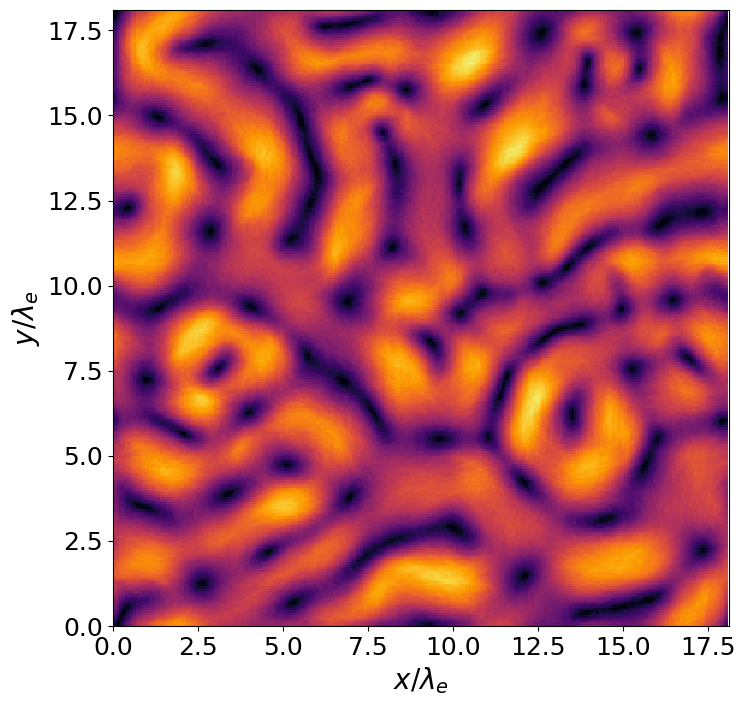

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

X, Y = np.meshgrid(y_coordinate, x_coordinate)

step = 1000
B = np.loadtxt(f'results/weibel_B_{step}.txt', delimiter=',').reshape(3, n_x, n_y)
mappable = ax.pcolormesh(X/electron_inertial_length, Y/electron_inertial_length, np.linalg.norm(B[:, :, :], axis=0), cmap='inferno', vmin=0.0, vmax=1.5)
ax.set_xlabel('$x / \lambda_e$', fontsize=20)
ax.set_ylabel('$y / \lambda_e$', fontsize=20)
ax.set_xlim(0.0, x_max/electron_inertial_length)
ax.set_ylim(0.0, y_max/electron_inertial_length)
ax.tick_params(labelsize=18)
ax.set_aspect('equal')

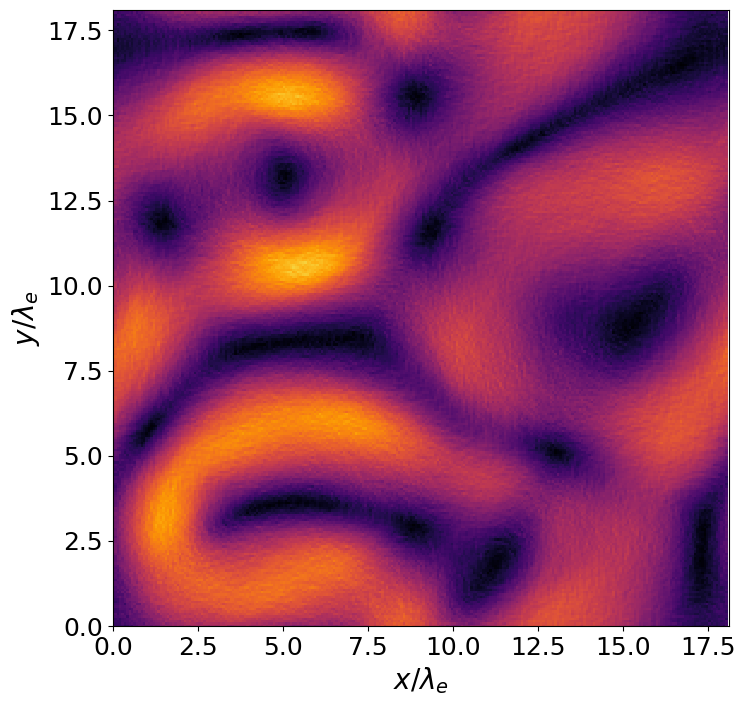

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

X, Y = np.meshgrid(y_coordinate, x_coordinate)

total_steps = 3000
interval = 100
for step in range(0, total_steps+1, interval):
    ax.clear()
    B = np.loadtxt(f'results/weibel_B_{step}.txt', delimiter=',').reshape(3, n_x, n_y)
    mappable = ax.pcolormesh(X/electron_inertial_length, Y/electron_inertial_length, np.linalg.norm(B[:, :, :], axis=0), cmap='inferno', vmin=0.0, vmax=1.5)
    ax.set_xlabel('$x / \lambda_e$', fontsize=20)
    ax.set_ylabel('$y / \lambda_e$', fontsize=20)
    ax.set_xlim(0.0, x_max/electron_inertial_length)
    ax.set_ylim(0.0, y_max/electron_inertial_length)
    ax.tick_params(labelsize=18)
    ax.set_aspect('equal')
    fig.savefig(f'./pictures/{step}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=f'weibel_B.mp4', fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()

##################################################

1.0599910086407787


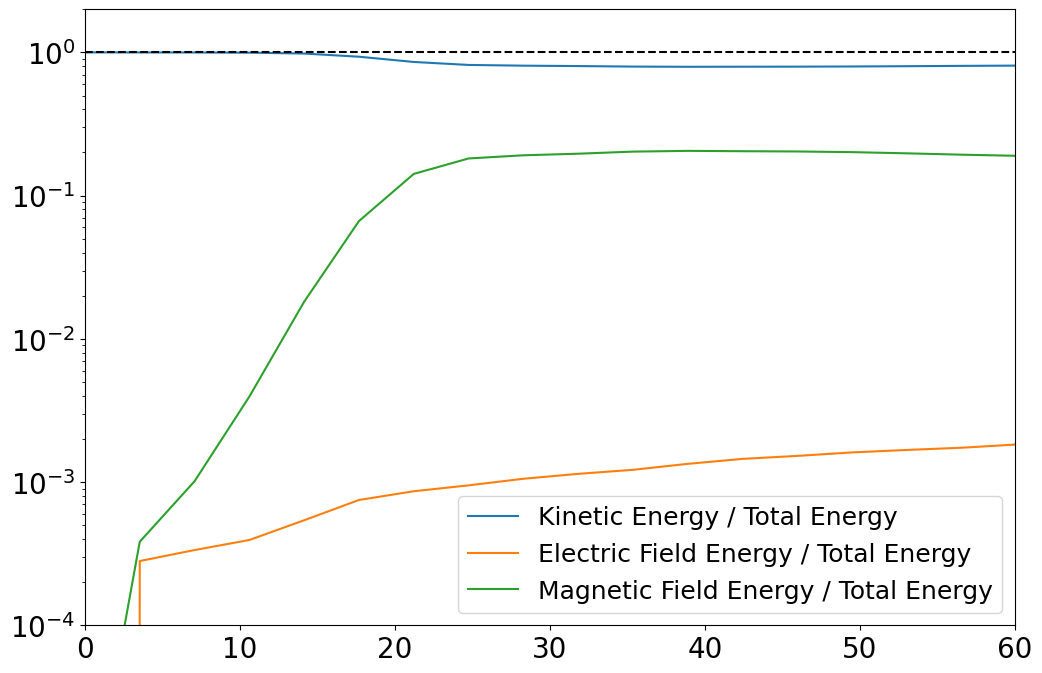

In [17]:
number_of_results = 31
kinetic_energy = np.zeros(number_of_results)
electric_field_energy = np.zeros(number_of_results)
magnetic_field_energy = np.zeros(number_of_results)
t = np.arange(0, number_of_results*100, 100)

for i in range(number_of_results):
    KE = np.loadtxt(f"./results/weibel_KE_{i*100}.txt")
    EE = np.loadtxt(f"./results/weibel_EEnergy_{i*100}.txt")
    BE = np.loadtxt(f"./results/weibel_BEnergy_{i*100}.txt")
    kinetic_energy[i] = KE
    electric_field_energy[i] = EE
    magnetic_field_energy[i] = BE

total_energy = kinetic_energy + electric_field_energy + magnetic_field_energy
print(total_energy[-1] / total_energy[0])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(t*omega_pe, kinetic_energy/total_energy, label='Kinetic Energy / Total Energy')
ax.plot(t*omega_pe, electric_field_energy/total_energy, label='Electric Field Energy / Total Energy')
ax.plot(t*omega_pe, magnetic_field_energy/total_energy, label='Magnetic Field Energy / Total Energy')
ax.hlines(1.0, xmin=0, xmax=number_of_results*100*omega_pe, ls='--', color='k')
ax.legend(loc='lower right', fontsize=18)
ax.set_xlim(0.0, 60)
ax.set_ylim(1e-4, 2)
ax.set_yscale('log')
ax.tick_params(labelsize=20)
fig.savefig("weibel_energy_raio.png")
plt.show()

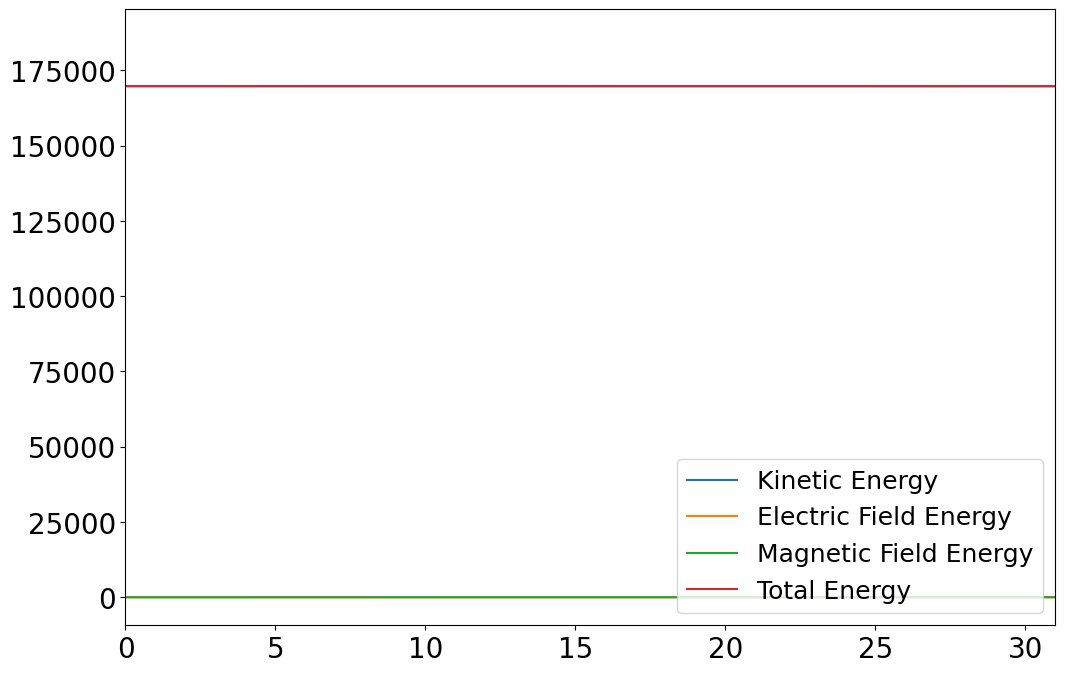

In [14]:
number_of_results = 31
kinetic_energy = np.zeros(number_of_results)
electric_field_energy = np.zeros(number_of_results)
magnetic_field_energy = np.zeros(number_of_results)
t = np.arange(0, number_of_results*100, 100)

for i in range(number_of_results):
    KE = np.loadtxt(f"./results/weibel_KE_{i*100}.txt")
    EE = np.loadtxt(f"./results/weibel_EEnergy_{i*100}.txt")
    BE = np.loadtxt(f"./results/weibel_BEnergy_{i*100}.txt")
    kinetic_energy[i] = KE
    electric_field_energy[i] = EE
    magnetic_field_energy[i] = BE

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(t, kinetic_energy, label='Kinetic Energy')
ax.plot(t, electric_field_energy, label='Electric Field Energy')
ax.plot(t, magnetic_field_energy, label='Magnetic Field Energy')
ax.plot(t, total_energy, label='Total Energy')
ax.legend(loc='lower right', fontsize=18)
ax.set_xlim(0.0, number_of_results)
ax.tick_params(labelsize=20)
fig.savefig("weibel_energy.png")
plt.show()